In [1]:
def extract_data(file_name):
    with open(file_name, 'r') as file:
        content = file.read()

    ligands = content.split('$$$$')
    results = {}
    counter = 1 

    for ligand in ligands:
        lines = [line.strip() for line in ligand.split('\n') if line.strip()]
        if len(lines) < 2: 
            continue
        name = str(lines[0])
        energy = None
        for i in range(len(lines)):
            if lines[i] == '> <r_user_dG.exp>':
                energy = lines[i + 1]
                break
     
        results[counter] = {"name": name, "df_exp": float(energy)}
        counter += 1 

    return results

data = extract_data('/home/b0rg3/Downloads/Inputs_for_FEP/Tyk2_ligands.sdf')
print(data)

for i in data.values():
    print(i)



{1: {'name': 'ejm_31', 'df_exp': -9.54}, 2: {'name': 'jmc_30', 'df_exp': -10.94}, 3: {'name': 'ejm_50', 'df_exp': -8.98}, 4: {'name': 'ejm_46', 'df_exp': -11.31}, 5: {'name': 'ejm_55', 'df_exp': -9.21}, 6: {'name': 'ejm_43', 'df_exp': -8.26}, 7: {'name': 'jmc_28', 'df_exp': -10.98}, 8: {'name': 'ejm_49', 'df_exp': -7.75}, 9: {'name': 'ejm_45', 'df_exp': -9.56}, 10: {'name': 'ejm_44', 'df_exp': -7.42}, 11: {'name': 'jmc_27', 'df_exp': -11.28}, 12: {'name': 'ejm_48', 'df_exp': -9.0}, 13: {'name': 'ejm_47', 'df_exp': -9.7}, 14: {'name': 'jmc_23', 'df_exp': -11.7}, 15: {'name': 'ejm_42', 'df_exp': -9.78}, 16: {'name': 'ejm_54', 'df_exp': -10.53}}
{'name': 'ejm_31', 'df_exp': -9.54}
{'name': 'jmc_30', 'df_exp': -10.94}
{'name': 'ejm_50', 'df_exp': -8.98}
{'name': 'ejm_46', 'df_exp': -11.31}
{'name': 'ejm_55', 'df_exp': -9.21}
{'name': 'ejm_43', 'df_exp': -8.26}
{'name': 'jmc_28', 'df_exp': -10.98}
{'name': 'ejm_49', 'df_exp': -7.75}
{'name': 'ejm_45', 'df_exp': -9.56}
{'name': 'ejm_44', 'df

In [2]:
null = None

l99a = extract_data('/home/b0rg3/Downloads/Inputs_for_FEP/Tyk2_ligands.sdf')  

ligands_map = {
    1: 'ejm_31',
    2: "jmc_30",
    3: "ejm_50",
    4: "ejm_46",
    5: "ejm_55",
    6: "ejm_43",
    7: "jmc_28",
    8: 'ejm_49',
    9: "ejm_45",
    10: "ejm_44",
    11: "jmc_27",
    12: "ejm_48",
    13: "ejm_47",
    14: "jmc_23",
    15: "ejm_42",
    16: "ejm_54",
}

In [3]:
from glob import glob
import pandas as pd
import pymbar
import os

experimental_affinities = list()
bar_energies = list()
exp_energies = list()
bar_errors = list()
exp_errors = list()
pair_dirs = list()
failed_pair_dirs = list()
pairs = list()

for pair_dir in glob(f"/home/b0rg3/Desktop/Tyk2/*-*"):
    results1 = list()
    results2 = list()
    results3 = list()
    
    pair = os.path.basename(pair_dir)
    
    print(f"Considering pair: {pair} at {pair_dir}")
    ligand1, ligand2 = map(int, pair.split("-"))
    
    
    
    ligand1_name = None
    ligand2_name = None
    for ligand_id in ligands_map:
        if ligand_id == ligand1:
            ligand1_name = ligands_map[ligand_id]
        if ligand_id == ligand2:
            ligand2_name = ligands_map[ligand_id]
        
        if ligand1_name is not None and ligand2_name is not None:
            break
    
    if ligand1_name is None:
        print(f"Ligand with id {ligand1} is unknown. Pair {pair} will be skipped")
        continue
    if ligand2_name is None:
        print(f"Ligand with id {ligand2} is unknown. Pair {pair} will be skipped")
        continue

    affinity1 = None
    affinity2 = None
    for ligand in l99a:

        if l99a[ligand]["name"] == ligand1_name:
            affinity1 = l99a[ligand]["df_exp"]
        if l99a[ligand]["name"] == ligand2_name:
            affinity2 = l99a[ligand]["df_exp"]
        
        if affinity1 is not None and affinity2 is not None:
            break
    
    if affinity1 is None:
        print(f"Experimental affinity for ligand with id {ligand1} is unknown. Pair {pair} will be skipped")
        continue
    if affinity2 is None:
        print(f"Experimental affinity for ligand with id {ligand2} is unknown. Pair {pair} will be skipped")
        continue
        
    skip = False
    bar_energy = None
    bar_error = None
    exp_energy = None
    exp_error = None
    with open(f"{pair_dir}/work/estimation.txt") as f:
        iter_lines = iter(f) 
        for line in iter_lines:
            if line.startswith("STATES"):
                n_states = int(line.split(":")[1].strip())
            
                if n_states != 16:
                    skip = True
                    print(f"Skipping pair {pair} since the number of states is not valid")
                    failed_pair_dirs.append(pair)
                    break
            
            elif line.startswith("BAR"):
                bar_energy = float(line.split(":")[1].replace("kcal/mol", "").strip())
                next_line = next(iter_lines, None)
                if next_line is not None:
                    bar_error = next_line.split(" ")[2].strip()
                    if bar_error == "nan":
                        bar_error = float(0.0)
                    else:
                        bar_error = float(bar_error)
                    
            elif line.startswith("EXP"):
                exp_energy = float(line.split(":")[1].replace("kcal/mol", "").strip())
                exp_error = float(line.split(":")[1].replace("+/-", "").replace("kcal/mol", "").strip())
    
    if skip:
        continue
    
    experimental_affinities.append(affinity2 - affinity1)
    bar_energies.append(bar_energy)
    bar_errors.append(bar_error)
    exp_energies.append(exp_energy)
    exp_errors.append(exp_error)
    pair_dirs.append(pair_dir)
    pairs.append((ligand1, ligand2))

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Considering pair: 1-8 at /home/b0rg3/Desktop/Tyk2/1-8
Considering pair: 1-11 at /home/b0rg3/Desktop/Tyk2/1-11
Considering pair: 15-3 at /home/b0rg3/Desktop/Tyk2/15-3
Considering pair: 1-4 at /home/b0rg3/Desktop/Tyk2/1-4
Considering pair: 1-3 at /home/b0rg3/Desktop/Tyk2/1-3
Considering pair: 15-16 at /home/b0rg3/Desktop/Tyk2/15-16
Considering pair: 2-4 at /home/b0rg3/Desktop/Tyk2/2-4
Considering pair: 11-14 at /home/b0rg3/Desktop/Tyk2/11-14
Considering pair: 15-8 at /home/b0rg3/Desktop/Tyk2/15-8
Skipping pair 15-8 since the number of states is not valid
Considering pair: 10-15 at /home/b0rg3/Desktop/Tyk2/10-15
Considering pair: 15-6 at /home/b0rg3/Desktop/Tyk2/15-6
Considering pair: 14-7 at /home/b0rg3/Desktop/Tyk2/14-7
Considering pair: 1-13 at /home/b0rg3/Desktop/Tyk2/1-13
Considering pair: 4-7 at /home/b0rg3/Desktop/Tyk2/4-7
Considering pair: 11-7 at /home/b0rg3/Desktop/Tyk2/11-7
Considering pair: 15-13 at /home/b0rg3/Desktop/Tyk2/15-13
Skipping pair 15-13 since the number of states 

In [4]:
for e0, e1, e2, e3, p in zip(experimental_affinities,
                    bar_energies,
                    exp_energies, bar_errors, pairs):
    print(e0, e1, e3, p)

1.7899999999999991 2.39 0.1 (1, 8)
-1.7400000000000002 0.0 0.0 (1, 11)
0.7999999999999989 1.17 0.03 (15, 3)
-1.7700000000000014 0.0 0.0 (1, 4)
0.5599999999999987 0.69 0.05 (1, 3)
-0.75 -0.91 0.03 (15, 16)
-0.370000000000001 1.0 0.04 (2, 4)
-0.41999999999999993 0.45 0.0 (11, 14)
-2.3599999999999994 -0.11 0.04 (10, 15)
1.5199999999999996 -0.52 0.0 (15, 6)
0.7199999999999989 -0.04 0.0 (14, 7)
-0.16000000000000014 -0.17 0.08 (1, 13)
0.33000000000000007 -0.33 0.03 (4, 7)
0.29999999999999893 0.36 0.0 (11, 7)
0.5699999999999985 -0.55 0.03 (15, 5)
-0.2400000000000002 -0.49 0.0 (1, 15)
-0.040000000000000924 0.1 0.0 (2, 7)
-0.8399999999999999 -0.28 0.03 (10, 6)
0.5399999999999991 3.93 0.11 (1, 12)
1.3199999999999985 0.65 0.05 (16, 5)


In [5]:
print(len(experimental_affinities))

20


 - Slope           0.42
 - Intercept       0.33
 - r value         0.35
 - p value         0.15


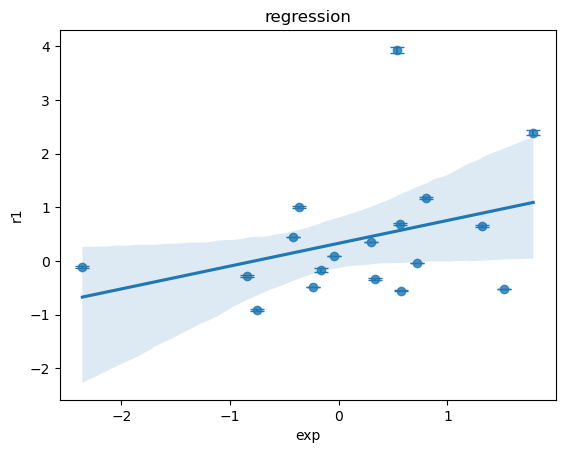

In [6]:
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt

estimator = "r1"

if estimator == "r1":
    error_label = "e1"
else:
    error_label = "e2"

results_df = pd.DataFrame(data={"exp": experimental_affinities,
                                "r1": bar_energies,
                                "r2": exp_energies,
                                "e1": bar_errors,
                                "e2": exp_errors})

results_df = results_df.dropna(axis=0)
results_df = results_df.drop(results_df[results_df["r1"] == 0.0].index)
results_df = results_df.drop(results_df[results_df["r2"] == 0.0].index)

# Remove predictions with a high error

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(results_df["exp"].to_list(),
                                                                  results_df[estimator].to_list())
print(" - Slope     {:10.2f}".format(slope))
print(" - Intercept {:10.2f}".format(intercept))
print(" - r value   {:10.2f}".format(r_value))
print(" - p value   {:10.2f}".format(p_value))


fig, ax = plt.subplots()
sns.regplot(x="exp", y=estimator, data=results_df, ax=ax).set(title=f"regression")
_ =ax.errorbar(x=results_df["exp"].to_list(),
               y=results_df[estimator].to_list(), yerr=[abs(i)/2.0 for i in results_df[error_label].tolist()],
               fmt='none', capsize=5, zorder=1, color='C0')


In [7]:
import networkx as nx

G = nx.Graph()

for ligand_id, ligand_name in ligands_map.items():
    affinity = None
    for ligand in l99a:
        if l99a[ligand]["name"] == ligand_name:
            affinity = l99a[ligand]["df_exp"]

    G.add_node(ligand_id, name=ligand_name,
               experimental_affinity=affinity)
    
assert len(bar_errors) == len(pair_dirs)
assert len(exp_errors) == len(pair_dirs)
assert len(bar_energies) == len(pair_dirs)
assert len(exp_energies) == len(pair_dirs)

for pair_dir, bar_error, exp_error, bar_energy, exp_energy in zip(
        pair_dirs, bar_errors, exp_errors, bar_energies, exp_energies):
    
    pair = os.path.basename(pair_dir)
    
    ligand1, ligand2 = map(int, pair.split("-"))
    
    G.add_edge(ligand1, ligand2, weight=bar_error,
               bar_error=bar_error, exp_error=exp_error,
               bar_energy=bar_energy, exp_energy=exp_energy,
               initial_ligand=ligand1,
               failed=False)

T = nx.minimum_spanning_tree(G)
    
for failed_pair in failed_pair_dirs:
    pair = os.path.basename(failed_pair)

    ligand1, ligand2 = map(int, pair.split("-"))
    
    G.add_edge(ligand1, ligand2, failed=True)

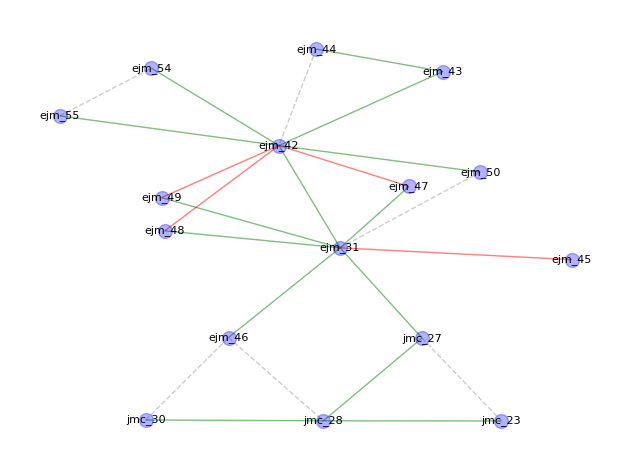

In [8]:
#pos = nx.spring_layout(T, k=1, seed=7)  # positions for all nodes - seed for reproducibility
#pos = nx.spring_layout(G, k=1, seed=7, pos=pos, fixed=T.nodes)  # positions for all nodes - seed for reproducibility

#pos = nx.shell_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

# nodes
nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.3, node_color="blue")

# node labels
node_labels = nx.get_node_attributes(G, "name")
nx.draw_networkx_labels(G, pos, node_labels, font_size=8,
                        font_family="sans-serif")
#nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edges
dashed_edges = []
red_edges = []
for e in G.edges:
    if not G.edges[e]["failed"]:
        if e not in T.edges:
            dashed_edges.append(e)
    else:
        red_edges.append(e)
nx.draw_networkx_edges(G, pos, edgelist=T.edges,
                       width=1, alpha=0.5, edge_color="green")
nx.draw_networkx_edges(G, pos, edgelist=dashed_edges,
                       width=1, alpha=0.2, edge_color="black", style="dashed")
nx.draw_networkx_edges(G, pos, edgelist=red_edges,
                       width=1, alpha=0.5, edge_color="red")

                       
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")

#nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.05)
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
def build_energy_map_from_nodes(node, graph, energy_map=None, relative=True):
    
    if energy_map is None:
        energy_map = dict()
        energy_map[node] = 0.0
        
    for edge in graph.edges(node):
        node1, node2 = edge

        e1 = graph.nodes[node1]["experimental_affinity"]
        e2 = graph.nodes[node2]["experimental_affinity"]
        
        if not relative:
            energy_map[node1] = e1
            
            if node2 not in energy_map:
                energy_map = build_energy_map_from_nodes(node2, graph, energy_map, relative)

        if node2 not in energy_map:
            eref = energy_map[node1]
            energy_map[node2] = eref + (e2 - e1)
            energy_map = build_energy_map_from_nodes(node2, graph, energy_map, relative)
        elif node1 not in energy_map:
            eref = energy_map[node2]
            energy_map[node1] = eref + (e1 - e2)
            energy_map = build_energy_map_from_nodes(node1, graph, energy_map, relative)
        
    return energy_map


def build_energy_map_from_edges(node, graph, energy_map=None, energy_label="bar_energy"):
    
    if energy_map is None:
        energy_map = dict()
        energy_map[node] = 0.0
        
    for edge in graph.edges(node):
        node1, node2 = edge
        energy = graph.edges[edge][energy_label]
        initial_ligand = graph.edges[edge]["initial_ligand"]
        
        if node2 == initial_ligand:
            energy = -energy
        
        if node2 not in energy_map:
            eref = energy_map[node1]
            energy_map[node2] = eref + energy
            energy_map = build_energy_map_from_edges(node2, graph, energy_map, energy_label)
        elif node1 not in energy_map:
            eref = energy_map[node2]
            energy_map[node1] = eref + energy
            energy_map = build_energy_map_from_edges(node1, graph, energy_map, energy_label)
        
    return energy_map


In [10]:
starting_node = 16
print(f"Starting ligand is: {T.nodes[starting_node]['name']}")
energy_map = dict()
energy_map[starting_node] = 0

energy_map1 = build_energy_map_from_nodes(starting_node, T)


energy_map2 = build_energy_map_from_edges(starting_node, T) 

print("-" * 37)
print("{:25} {:>5} {:>5}".format("Ligand", "EXP", "COMP"))
print("-" * 37)
for node, energy in energy_map1.items():
    print("{:25} {:+5.1f} {:+5.1f}".format(T.nodes[node]['name'], energy, energy_map2[node]))


Starting ligand is: ejm_54
-------------------------------------
Ligand                      EXP  COMP
-------------------------------------
ejm_54                     +0.0  +0.0
ejm_42                     +0.8  +0.9
ejm_31                     +1.0  +1.4
jmc_27                     -0.8  +1.4
jmc_28                     -0.5  +1.8
jmc_30                     -0.4  +1.7
jmc_23                     -1.2  +1.8
ejm_46                     -0.8  +1.4
ejm_47                     +0.8  +1.2
ejm_49                     +2.8  +3.8
ejm_48                     +1.5  +5.3
ejm_43                     +2.3  +0.4
ejm_44                     +3.1  +0.7
ejm_50                     +1.5  +2.1
ejm_55                     +1.3  +0.4


     exp    r1
0   0.00  0.00
1   0.75  0.91
2   0.99  1.40
3  -0.75  1.40
4  -0.45  1.76
5  -0.41  1.66
6  -1.17  1.80
7  -0.78  1.40
8   0.83  1.23
9   2.78  3.79
10  1.53  5.33
11  2.27  0.39
12  3.11  0.67
13  1.55  2.08
14  1.32  0.36
 - Slope                      0.26
 - Intercept                  1.52
 - r value                    0.25
 - p value                    0.38


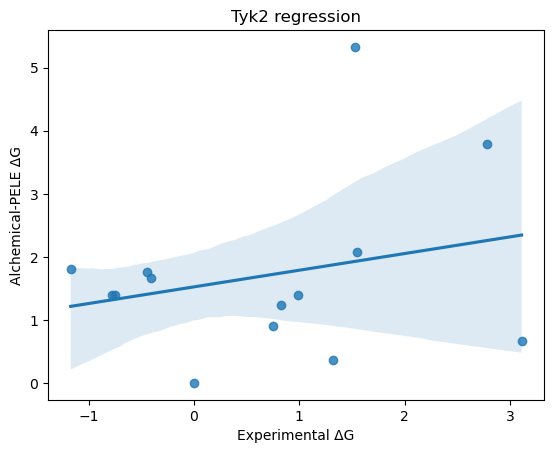

In [16]:
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
import numpy as np

energies1 = list()
energies2 = list()
for node in energy_map1.keys():
    energies1.append(energy_map1[node])
    energies2.append(energy_map2[node])

results_df = pd.DataFrame(data={"exp": energies1,
                                "r1": energies2})
print(results_df)
results_df = results_df.drop(11)

results_df = results_df.drop(results_df[results_df["r1"] > 100].index)

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(results_df["exp"].to_list(),
                                                                  results_df["r1"].to_list())
print(" - Slope                {:10.2f}".format(slope))
print(" - Intercept            {:10.2f}".format(intercept))
print(" - r value              {:10.2f}".format(r_value))
print(" - p value              {:10.2f}".format(p_value))

#res = sp.stats.pearsonr(results_df["exp"].to_list(),
#                        results_df["r1"].to_list())
#print(" - Pearson correlation: {:10.2f}".format(res.correlation))

#error = list()
#for v1, v2 in zip(results_df["exp"].to_list(), results_df["r1"].to_list()):
#    error.append(abs(v1 - v2))
#print(" - Mean absolute error: {:10.2f}".format(np.mean(error)))


fig, ax = plt.subplots()
_ = sns.regplot(x="exp", y="r1", data=results_df, ax=ax).set(title=f"Tyk2 regression")
ax.set_xlabel("Experimental ΔG")
ax.set_ylabel("Alchemical-PELE ΔG")

results_df.to_csv('results.csv', index=False)
